##IMPORTACIONES


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal.signaltools
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM

from sklearn.preprocessing import MinMaxScaler
import random  # Importa el módulo random
import tensorflow as tf

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE


import warnings
warnings.filterwarnings("ignore")


## SUAVIZACIONES EXPONENCIALES

In [ ]:
def predict_using_smoothexponential(df , n_output):

    sku = df['ID'].unique()

    pronosticos_smoothexponential = pd.DataFrame(columns=['ID', 'COD_SKU_SAP', 'UND_ORDEN', 'HWES2_ADD', 'HWES2_MUL', 'HWES3_MM', 'HWES3_MA', 'HWES3_AM', 'HWES3_AA'])

    for n in sku:

        nuevo = df[df['ID'] == n]
        total_reg = len(nuevo)

        train = nuevo[:total_reg-n_output]
        test = nuevo[total_reg-n_output:]


        model_HWES2_MUL = ExponentialSmoothing(train['UND_ORDEN'], trend='mul').fit(optimized=True)
        model_HWES2_ADD = ExponentialSmoothing(train['UND_ORDEN'], trend='add').fit(optimized=True)
        sm_exp3_mm = ExponentialSmoothing(train['UND_ORDEN'], trend='mul', seasonal='mul', seasonal_periods=12).fit(optimized=True)
        sm_exp3_ma = ExponentialSmoothing(train['UND_ORDEN'], trend='mul', seasonal='add', seasonal_periods=12).fit(optimized=True)
        sm_exp3_am = ExponentialSmoothing(train['UND_ORDEN'], trend='add', seasonal='mul', seasonal_periods=12).fit(optimized=True)
        sm_exp3_aa = ExponentialSmoothing(train['UND_ORDEN'], trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)

        COD_SKU_SAP_value = test.loc[test['ID'] == n, 'COD_SKU_SAP'].tolist()
        und_orden = test.loc[test['ID'] == n, 'UND_ORDEN'].tolist()

        pronosticos_temp = pd.DataFrame({
            'ID': [n] * len(model_HWES2_ADD.forecast(n_output)),
            'COD_SKU_SAP': COD_SKU_SAP_value,
            'UND_ORDEN': und_orden,
            'HWES2_ADD': model_HWES2_ADD.forecast(n_output),
            'HWES2_MUL': model_HWES2_MUL.forecast(n_output),
            'HWES3_MM': pd.Series(sm_exp3_mm.forecast(n_output)),
            'HWES3_MA': pd.Series(sm_exp3_ma.forecast(n_output)),
            'HWES3_AM': pd.Series(sm_exp3_am.forecast(n_output)),
            'HWES3_AA': pd.Series(sm_exp3_aa.forecast(n_output))
        })
        pronosticos_smoothexponential = pronosticos_smoothexponential.append(pronosticos_temp, ignore_index=True)

    return pronosticos_smoothexponential



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Udemy/TESIS/datax.csv', sep='|', encoding='latin-1')
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%d/%m/%Y')
df.set_index('FECHA', inplace=True)

n_output=7

pronosticos_smoothexponential = predict_using_smoothexponential(df , n_output)


In [ ]:
pronosticos_smoothexponential

,ID,COD_SKU_SAP,UND_ORDEN,HWES2_ADD,HWES2_MUL,HWES3_MM,HWES3_MA,HWES3_AM,HWES3_AA
0,1,4,582,600.905699,584.800603,765.755110,777.784045,762.092519,779.075716
1,1,4,663,594.715220,563.458677,630.177019,604.107050,625.439463,620.454464
2,1,4,626,588.524742,542.895611,804.478824,755.493448,795.846890,798.146010
3,1,4,666,582.334264,523.082981,813.659341,692.420365,800.220204,784.176415
4,1,4,743,576.143786,503.993400,719.081915,642.497803,701.817640,675.754519
...,...,...,...,...,...,...,...,...,...
135,55,666,655,812.172923,808.664530,704.566244,714.867829,673.063974,700.269108
136,55,666,800,824.969642,818.705905,729.930124,746.749024,716.819200,729.684290
137,55,666,1016,837.766361,828.871966,878.916073,853.501768,864.999228,828.162327
138,55,666,974,850.563079,839.164261,834.739638,826.513270,814.376567,786.843786


In [ ]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE

metric_error_MAE =  pd.DataFrame(columns=['ID','COD_SKU_SAP', 'HWES2_ADD','HWES2_MUL','HWES3_MM','HWES3_MA','HWES3_AM','HWES3_AA'])
metric_error_MSE =  pd.DataFrame(columns=['ID','COD_SKU_SAP', 'HWES2_ADD','HWES2_MUL','HWES3_MM','HWES3_MA','HWES3_AM','HWES3_AA'])
metric_error_MAPE = pd.DataFrame(columns=['ID','COD_SKU_SAP', 'HWES2_ADD','HWES2_MUL','HWES3_MM','HWES3_MA','HWES3_AM','HWES3_AA'])

sku = pronosticos_smoothexponential['ID'].unique()

for n in sku:
    nuevo = pronosticos_smoothexponential[pronosticos_smoothexponential['ID'] == n]


    test=nuevo["UND_ORDEN"]
    sm_exp2_add=nuevo['HWES2_ADD']
    sm_exp2_mul=nuevo['HWES2_MUL']
    sm_exp3_mm=nuevo['HWES3_MM']
    sm_exp3_ma=nuevo['HWES3_MA']
    sm_exp3_am=nuevo['HWES3_AM']
    sm_exp3_aa=nuevo['HWES3_AA']

    COD_SKU_SAP_value = nuevo.loc[nuevo['ID'] == n, 'COD_SKU_SAP'].unique()


    metric_error_MAE_temp = pd.DataFrame({
        'ID': [n] ,
        'COD_SKU_SAP':COD_SKU_SAP_value,
        'HWES2_ADD': MAE(test,sm_exp2_add),
        'HWES2_MUL': MAE(test,sm_exp2_mul),
        'HWES3_MM': MAE(test,sm_exp3_mm),
        'HWES3_MA': MAE(test,sm_exp3_ma),
        'HWES3_AM': MAE(test,sm_exp3_am),
        'HWES3_AA': MAE(test,sm_exp3_aa)
    })
    metric_error_MAE = metric_error_MAE.append(metric_error_MAE_temp, ignore_index=True)

    metric_error_MSE_temp = pd.DataFrame({
        'ID': [n] ,
        'COD_SKU_SAP':COD_SKU_SAP_value,
        'HWES2_ADD': MSE(test,sm_exp2_add),
        'HWES2_MUL': MSE(test,sm_exp2_mul),

        'HWES3_MM': MSE(test,sm_exp3_mm),
        'HWES3_MA': MSE(test,sm_exp3_ma),
        'HWES3_AM': MSE(test,sm_exp3_am),
        'HWES3_AA': MSE(test,sm_exp3_aa)
    })
    metric_error_MSE = metric_error_MSE.append(metric_error_MSE_temp, ignore_index=True)


    metric_error_MAPE_temp = pd.DataFrame({
        'ID': [n] ,
        'COD_SKU_SAP':COD_SKU_SAP_value,
        'HWES2_ADD': MAPE(test,sm_exp2_add),
        'HWES2_MUL': MAPE(test,sm_exp2_mul),

        'HWES3_MM': MAPE(test,sm_exp3_mm),
        'HWES3_MA': MAPE(test,sm_exp3_ma),
        'HWES3_AM': MAPE(test,sm_exp3_am),
        'HWES3_AA': MAPE(test,sm_exp3_aa)
    })
    metric_error_MAPE = metric_error_MAPE.append(metric_error_MAPE_temp, ignore_index=True)


# Obtener el valor mínimo entre las columnas 'metod_abc' y 'metod_zzz'
metric_error_MAE['EXPSMOOTH_MAE'] = metric_error_MAE[['HWES2_ADD', 'HWES2_MUL','HWES3_MM','HWES3_MA','HWES3_AM','HWES3_AA']].min(axis=1)
metric_error_MSE['EXPSMOOTH_MSE'] = metric_error_MSE[['HWES2_ADD', 'HWES2_MUL','HWES3_MM','HWES3_MA','HWES3_AM','HWES3_AA']].min(axis=1)
metric_error_MAPE['EXPSMOOTH_MAPE'] = metric_error_MAPE[['HWES2_ADD', 'HWES2_MUL','HWES3_MM','HWES3_MA','HWES3_AM','HWES3_AA']].min(axis=1)

# Determinar el método correspondiente al valor mínimo
metric_error_MAE['MET_SMEXP_MAE'] = metric_error_MAE[['HWES2_ADD', 'HWES2_MUL','HWES3_MM','HWES3_MA','HWES3_AM','HWES3_AA']].idxmin(axis=1)
metric_error_MSE['MET_SMEXP_MSE'] = metric_error_MSE[['HWES2_ADD', 'HWES2_MUL','HWES3_MM','HWES3_MA','HWES3_AM','HWES3_AA']].idxmin(axis=1)
metric_error_MAPE['MET_SMEXP_MAPE'] = metric_error_MAPE[['HWES2_ADD', 'HWES2_MUL','HWES3_MM','HWES3_MA','HWES3_AM','HWES3_AA']].idxmin(axis=1)


# Crear el nuevo DataFrame con las columnas 'ID', 'metodo' y 'valor'
metric_error_MAE = metric_error_MAE[['ID', 'COD_SKU_SAP','MET_SMEXP_MAE', 'EXPSMOOTH_MAE']]
metric_error_MSE = metric_error_MSE[['ID', 'MET_SMEXP_MSE', 'EXPSMOOTH_MSE']]
metric_error_MAPE= metric_error_MAPE[['ID', 'MET_SMEXP_MAPE', 'EXPSMOOTH_MAPE']]

metric_error_MSE['EXPSMOOTH_MSE']=metric_error_MSE['EXPSMOOTH_MSE'].astype(int)

resumen_metricas_error_SMEXP = pd.merge(pd.merge(metric_error_MAE, metric_error_MSE, on='ID', how='inner'),metric_error_MAPE, on='ID', how='inner')

resumen_metricas_error_SMEXP

,ID,COD_SKU_SAP,MET_SMEXP_MAE,EXPSMOOTH_MAE,MET_SMEXP_MSE,EXPSMOOTH_MSE,MET_SMEXP_MAPE,EXPSMOOTH_MAPE
0,1,4,HWES3_MA,105.579743,HWES3_MA,15332,HWES3_MA,0.233142
1,2,6,HWES3_MA,18.891828,HWES3_MA,602,HWES3_MA,0.073794
2,3,18,HWES2_ADD,19.060971,HWES3_MA,564,HWES2_ADD,0.126649
3,5,31,HWES2_ADD,59.273289,HWES2_ADD,4420,HWES2_ADD,0.257136
4,6,33,HWES2_ADD,14.138480,HWES2_ADD,492,HWES2_ADD,0.092632
5,7,38,HWES2_MUL,22.023314,HWES2_MUL,563,HWES2_MUL,0.350436
6,8,42,HWES2_MUL,15.941093,HWES2_MUL,357,HWES2_MUL,0.129711
7,19,224,HWES3_AM,4.400914,HWES3_AM,28,HWES3_AM,0.118164
8,20,228,HWES3_MM,84.602078,HWES3_AA,22142,HWES3_MM,0.183131
9,24,262,HWES2_MUL,100.911926,HWES2_MUL,11193,HWES2_MUL,0.399778


In [ ]:
metric_error_MAPE

# SARIMAX ALL IN ONE

In [ ]:
!pip install pmdarima


In [ ]:
from pmdarima import auto_arima

In [ ]:
def predict_using_sarima(df , n_output):

    sku = df['ID'].unique()

    pronosticos_sarima = pd.DataFrame(columns=['ID', 'COD_SKU_SAP', 'UND_ORDEN', 'AR', 'I', 'MA', 'SO_AR', 'SO_D', 'SO_MA', 'SARIMA'])

    for n in sku:

        nuevo = df[df['ID'] == n]
        total_reg = len(nuevo)


        train = nuevo.iloc[:total_reg-n_output]
        test = nuevo.iloc[total_reg-n_output:]


        model_auto2 = auto_arima(train.UND_ORDEN, m=12, max_order=None, max_p=9, max_q=9, max_d=2, max_P=5, max_Q=5, max_D=3, maxiter=60, alpha=0.05, n_jobs=-1, trend='ct', information_criterion='oob', out_of_sample_size=5)

        ar = model_auto2.order[0]
        i = model_auto2.order[1]
        ma = model_auto2.order[2]
        so_ar = model_auto2.seasonal_order[0]
        so_d = model_auto2.seasonal_order[1]
        so_ma = model_auto2.seasonal_order[2]

        model = SARIMAX(train.UND_ORDEN, order=(ar, i, ma), seasonal_order=(so_ar, so_d, so_ma, 12))
        result = model.fit()

        COD_SKU_SAP_value = test.loc[test['ID'] == n, 'COD_SKU_SAP'].tolist()
        und_orden = test.loc[test['ID'] == n, 'UND_ORDEN'].tolist()

        pronosticos_temp = pd.DataFrame({
            'ID': [n] * len(result.forecast(n_output)),
            'COD_SKU_SAP': COD_SKU_SAP_value,
            'UND_ORDEN': und_orden,
            'AR': ar,
            'I': i,
            'MA': ma,
            'SO_AR': so_ar,
            'SO_D': so_d,
            'SO_MA': so_ma,
            'SARIMA': result.forecast(n_output)
        })
        pronosticos_sarima = pronosticos_sarima.append(pronosticos_temp, ignore_index=True)

    return pronosticos_sarima

In [ ]:
# Llamar a la función y guardar el DataFrame resultante en una variable

df = pd.read_csv('/content/drive/MyDrive/Udemy/TESIS/datax.csv', sep='|', encoding='latin-1')
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%d/%m/%Y')
df.set_index('FECHA', inplace=True)

n_output=7


pronosticos_sarima = predict_using_sarima(df , n_output)

In [ ]:
pronosticos_sarima

,ID,COD_SKU_SAP,UND_ORDEN,AR,I,MA,SO_AR,SO_D,SO_MA,SARIMA
0,1,4,582,1,0,0,0,0,0,583.210821
1,1,4,663,1,0,0,0,0,0,560.353974
2,1,4,626,1,0,0,0,0,0,538.392918
3,1,4,666,1,0,0,0,0,0,517.292547
4,1,4,743,1,0,0,0,0,0,497.019129
...,...,...,...,...,...,...,...,...,...,...
135,55,666,655,1,1,0,5,0,0,593.205173
136,55,666,800,1,1,0,5,0,0,607.606979
137,55,666,1016,1,1,0,5,0,0,601.567108
138,55,666,974,1,1,0,5,0,0,561.501646


In [ ]:


metric_error_MAE =  pd.DataFrame(columns=['ID','COD_SKU_SAP', 'SARIMA_MAE'])
metric_error_MSE =  pd.DataFrame(columns=['ID','COD_SKU_SAP', 'SARIMA_MSE'])
metric_error_MAPE = pd.DataFrame(columns=['ID','COD_SKU_SAP', 'SARIMA_MAPE'])

sku = pronosticos_sarima['ID'].unique()

for n in sku:
    nuevo = pronosticos_sarima[pronosticos_sarima['ID'] == n]

    test=nuevo["UND_ORDEN"]
    sarima=nuevo['SARIMA']


    COD_SKU_SAP_value = nuevo.loc[nuevo['ID'] == n, 'COD_SKU_SAP'].unique()


    metric_error_MAE_temp = pd.DataFrame({
        'ID': [n] ,
        'COD_SKU_SAP':COD_SKU_SAP_value,
        'SARIMA_MAE': MAE(test,sarima)
    })
    metric_error_MAE = metric_error_MAE.append(metric_error_MAE_temp, ignore_index=True)

    metric_error_MSE_temp = pd.DataFrame({
        'ID': [n] ,
        'COD_SKU_SAP':COD_SKU_SAP_value,
        'SARIMA_MSE': MSE(test,sarima)
        })
    metric_error_MSE = metric_error_MSE.append(metric_error_MSE_temp, ignore_index=True)


    metric_error_MAPE_temp = pd.DataFrame({
        'ID': [n] ,
        'COD_SKU_SAP':COD_SKU_SAP_value,
        'SARIMA_MAPE': MAPE(test,sarima),
        'AR':nuevo['AR'].unique(),
        'I': nuevo['I'].unique(),
        'MA':nuevo['MA'].unique(),
        'SO_AR':nuevo['SO_AR'].unique(),
        'SO_D':nuevo['SO_D'].unique(),
        'SO_MA':nuevo['SO_MA'].unique()
    })
    metric_error_MAPE = metric_error_MAPE.append(metric_error_MAPE_temp, ignore_index=True)



metric_error_MSE = metric_error_MSE.drop('COD_SKU_SAP', axis=1)
metric_error_MAPE = metric_error_MAPE.drop('COD_SKU_SAP', axis=1)

resumen_metricas_error_SARIMA = pd.merge(pd.merge(metric_error_MAE, metric_error_MSE, on='ID', how='inner'),metric_error_MAPE, on='ID', how='inner')

resumen_metricas_error_SARIMA['MET_SARIMA']='('+resumen_metricas_error_SARIMA['AR'].astype(str)  +','+ resumen_metricas_error_SARIMA['I'].astype(str)  +','+  resumen_metricas_error_SARIMA['MA'].astype(str) +')('+ resumen_metricas_error_SARIMA['SO_AR'].astype(str) +','+ resumen_metricas_error_SARIMA['SO_D'].astype(str) +','+ resumen_metricas_error_SARIMA['SO_MA'].astype(str) + ',12)'
resumen_metricas_error_SARIMA[['COD_SKU_SAP','MET_SARIMA','SARIMA_MAPE']]

,COD_SKU_SAP,MET_SARIMA,SARIMA_MAPE
0,4,"(1,0,0)(0,0,0,12)",0.255633
1,6,"(0,1,1)(0,0,0,12)",0.092710
2,18,"(0,1,1)(1,0,0,12)",0.221094
3,31,"(0,1,0)(0,0,0,12)",0.488216
4,33,"(0,1,0)(1,0,0,12)",0.101053
5,38,"(2,1,2)(1,0,1,12)",0.206036
6,42,"(0,1,0)(2,0,0,12)",0.113460
7,224,"(3,0,0)(0,0,2,12)",0.326339
8,228,"(4,0,1)(2,0,0,12)",0.351833
9,262,"(3,0,0)(0,0,0,12)",0.268814


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Run

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['SARIMA_MAPE'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_1, *['SARIMA_MAPE'], **{})
chart

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


# REDES NEURONALES

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

data = pd.read_csv("/content/drive/MyDrive/Udemy/TESIS/datax.csv", sep='|', encoding='latin-1')

data=data[data['ID'] == 1]




In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("/content/drive/MyDrive/Udemy/TESIS/datax.csv", sep='|', encoding='latin-1')

data=data[data['ID'] == 1]

# Supongamos que 'data' es tu DataFrame con las columnas 'FECHA' y 'UND_ORDEN'
# Convierte la columna 'FECHA' en el número de días desde una fecha de referencia
data['FECHA'] = pd.to_datetime(data['FECHA'])
data['DAYS_SINCE_REFERENCE'] = (data['FECHA'] - pd.Timestamp('1970-01-01')).dt.days

# Selecciona las características de entrada y la variable objetivo
X = data['DAYS_SINCE_REFERENCE'].values.reshape(-1, 1)
y = data['UND_ORDEN'].values.reshape(-1, 1)

# Normaliza los valores de entrada y salida
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define la arquitectura de la red neuronal
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, input_dim=1, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='linear')  # Capa de salida con activación lineal
])

# Compila el modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenamiento de la red neuronal
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.2)

# Evalúa el modelo en el conjunto de prueba
loss = model.evaluate(X_test, y_test)
print(f'Error cuadrático medio en el conjunto de prueba: {loss}')

# Realiza predicciones
y_pred = model.predict(X_test)

# Desnormaliza las predicciones
y_pred = scaler_y.inverse_transform(y_pred)

# Imprime las predicciones y las comparaciones con los valores reales

for i in range(len(y_test)):
    print(f'Valor real: {scaler_y.inverse_transform(y_test)[i][0]}, Predicción: {y_pred[i][0]}')



Epoch 1/100
2/2 [==============================] - 1s 188ms/step - loss: 0.0493 - val_loss: 0.0795
Epoch 2/100
2/2 [==============================] - 0s 60ms/step - loss: 0.0472 - val_loss: 0.0771
Epoch 3/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0452 - val_loss: 0.0747
Epoch 4/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0433 - val_loss: 0.0725
Epoch 5/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0415 - val_loss: 0.0704
Epoch 6/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0397 - val_loss: 0.0683
Epoch 7/100
2/2 [==============================] - 0s 45ms/step - loss: 0.0382 - val_loss: 0.0664
Epoch 8/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0367 - val_loss: 0.0646
Epoch 9/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0353 - val_loss: 0.0628
Epoch 10/100
2/2 [==============================] - 0s 43ms/step - loss: 0.0340 - val_loss: 0.0612
Epoch 11/100
2/2 [

In [39]:
for i in range(len(y_test)):
    print(f'Valor real: {scaler_y.inverse_transform(y_test)[i][0]}, Predicción: {y_pred[i][0]}')



Valor real: 880.0000000000001, Predicción: 726.5519409179688
Valor real: 760.0, Predicción: 710.1795654296875
Valor real: 1014.0, Predicción: 701.801025390625
Valor real: 494.00000000000006, Predicción: 701.9164428710938
Valor real: 693.0, Predicción: 726.7516479492188
Valor real: 1419.0, Predicción: 726.6406860351562
Valor real: 663.0, Predicción: 742.4942016601562
Valor real: 831.0, Predicción: 701.8240966796875
Valor real: 743.0, Predicción: 742.5584716796875
Valor real: 783.0, Predicción: 710.0882568359375
Valor real: 562.0, Predicción: 718.3892822265625
Valor real: 607.0, Predicción: 734.8246459960938
Valor real: 268.0, Predicción: 718.4568481445312
Valor real: 980.0, Predicción: 701.7086791992188


In [43]:
data[:70]

,ID,COD_SKU_SAP,UND_ORDEN,FECHA,DAYS_SINCE_REFERENCE
0,1,4,980,2018-01-01,17532
1,1,4,802,2018-01-02,17533
2,1,4,843,2018-01-03,17534
3,1,4,722,2018-01-04,17535
4,1,4,1014,2018-01-05,17536
...,...,...,...,...,...
62,1,4,626,2023-01-03,19360
63,1,4,666,2023-01-04,19361
64,1,4,743,2023-01-05,19362
65,1,4,255,2023-01-06,19363


## LSTM

In [ ]:

seed_value = 42

def predict_using_lstm(df, n_output, n_epochs):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    pronosticos_rn_lstm = pd.DataFrame(columns=['ID','COD_SKU_SAP', 'UND_ORDEN', 'LSTM'])

    sku_list =  df['ID'].unique()

    for n in sku_list:

        nuevo = df[df['ID'] == n]
        total_reg = len(nuevo)

        COD_SKU_SAP = nuevo[['COD_SKU_SAP']][total_reg - n_output:]
        ID = nuevo[['ID']][total_reg - n_output:]
        FECHA_ORDEN = nuevo.index[total_reg - n_output:]


        nuevo = nuevo[['UND_ORDEN']]
        train = nuevo[:total_reg - n_output]
        test = nuevo[total_reg - n_output:]

        scaler = MinMaxScaler()
        scaler.fit(train)

        scaled_train = scaler.transform(train)
        scaled_test = scaler.transform(test)

        generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_output, batch_size=1)
        X, y = generator[0]

        n_features = 1

        model = Sequential()
        model.add(LSTM(100, activation='relu', input_shape=(n_output, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit_generator(generator, epochs=n_epochs)

        first_eval_batch = scaled_train[-n_output:]
        first_eval_batch = first_eval_batch.reshape((1, n_output, n_features))
        predictions = []

        current_batch = first_eval_batch.copy()

        for i in range(len(test)):
            current_pred = model.predict(current_batch)[0]
            predictions.append(current_pred)
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

        true_predictions = scaler.inverse_transform(predictions)

        test['ID'] = ID
        test['COD_SKU_SAP'] = COD_SKU_SAP
        test['FECHA_ORDEN'] = FECHA_ORDEN
        test['LSTM'] = true_predictions


        pronosticos_rn_lstm = pd.concat([pronosticos_rn_lstm, test])

    pronosticos_rn_lstm.set_index('FECHA_ORDEN', inplace=True)  # Establece 'FECHA_ORDEN' como índice

    return pronosticos_rn_lstm

In [ ]:
data_path = "/content/drive/MyDrive/Udemy/TESIS/datax.csv"
df = pd.read_csv(data_path, sep='|', encoding='latin-1')
df.set_index('FECHA', inplace=True)

n_output = 7
n_epochs = 100


pronosticos_rn_lstm = predict_using_lstm(df, n_output, n_epochs)

In [ ]:
pronosticos_rn_lstm

,ID,COD_SKU_SAP,UND_ORDEN,LSTM
FECHA_ORDEN,,,,
1/01/2023,1,4,582,680.074629
1/02/2023,1,4,663,744.128921
1/03/2023,1,4,626,782.607242
1/04/2023,1,4,666,763.985298
1/05/2023,1,4,743,742.936965
...,...,...,...,...
1/03/2023,55,666,655,724.604112
1/04/2023,55,666,800,735.672783
1/05/2023,55,666,1016,745.784357


## GRU

In [ ]:

seed_value = 42

# ... importaciones ...

def predict_using_gru(df, n_input, n_epochs):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    pronosticos_rn_gru = pd.DataFrame(columns=['ID','COD_SKU_SAP', 'UND_ORDEN', 'GRU'])

    sku_list =  df['ID'].unique()

    for n in sku_list:

        nuevo = df[df['ID'] == n]
        total_reg = len(nuevo)
        ID = nuevo[['ID']][total_reg - n_input:]
        COD_SKU_SAP = nuevo[['COD_SKU_SAP']][total_reg - n_input:]
        FECHA_ORDEN = nuevo.index[total_reg - n_input:]

        nuevo = nuevo[['UND_ORDEN']]
        train = nuevo[:total_reg - n_input]
        test = nuevo[total_reg - n_input:]

        scaler = MinMaxScaler()
        scaler.fit(train)

        scaled_train = scaler.transform(train)
        scaled_test = scaler.transform(test)

        generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
        X, y = generator[0]

        n_features = 1

        model = Sequential()
        model.add(GRU(100, activation='relu', input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit_generator(generator, epochs=n_epochs)

        first_eval_batch = scaled_train[-n_input:]
        first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
        predictions = []

        current_batch = first_eval_batch.copy()

        for i in range(len(test)):
            current_pred = model.predict(current_batch)[0]
            predictions.append(current_pred)
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

        true_predictions = scaler.inverse_transform(predictions)

        test['ID'] = ID
        test['GRU'] = true_predictions
        test['COD_SKU_SAP'] = COD_SKU_SAP
        test['FECHA_ORDEN'] = FECHA_ORDEN

        pronosticos_rn_gru = pd.concat([pronosticos_rn_gru, test])

    pronosticos_rn_gru.set_index('FECHA_ORDEN', inplace=True)  # Establece 'FECHA_ORDEN' como índice

    return pronosticos_rn_gru

In [ ]:
data_path = "/content/drive/MyDrive/Udemy/TESIS/datax.csv"
df = pd.read_csv(data_path, sep='|', encoding='latin-1')
df.set_index('FECHA', inplace=True)


n_input = 7
n_epochs = 100

pronosticos_rn_gru = predict_using_gru(df , n_input, n_epochs)

Epoch 1/100
53/53 [==============================] - 3s 9ms/step - loss: 0.0431
Epoch 2/100
53/53 [==============================] - 1s 9ms/step - loss: 0.0269
Epoch 3/100
53/53 [==============================] - 1s 9ms/step - loss: 0.0269
Epoch 4/100
53/53 [==============================] - 1s 12ms/step - loss: 0.0264
Epoch 5/100
53/53 [==============================] - 0s 9ms/step - loss: 0.0266
Epoch 6/100
53/53 [==============================] - 0s 7ms/step - loss: 0.0253
Epoch 7/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0239
Epoch 8/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0243
Epoch 9/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0233
Epoch 10/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0236
Epoch 11/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0226
Epoch 12/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0212
Epoch 13/100
53/53 [================

## TCN

In [ ]:
!git clone https://github.com/philipperemy/keras-tcn.git


Cloning into 'keras-tcn'...
remote: Enumerating objects: 1918, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 1918 (delta 46), reused 57 (delta 22), pack-reused 1821
Receiving objects: 100% (1918/1918), 5.85 MiB | 15.85 MiB/s, done.
Resolving deltas: 100% (1004/1004), done.


In [ ]:
cd keras-tcn

/content/keras-tcn


In [ ]:
!pip install .

Processing /content/keras-tcn
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.9 MB/s eta 0:00:00
  Created wheel for keras-tcn: filename=keras_tcn-3.5.0-py3-none-any.whl size=13123 sha256=c5b83a90b08850e3ae480f7ba2175ddace997aa251e3aaffc21c7ca86eda8d7a
  Stored in directory: /root/.cache/pip/wheels/45/f1/7d/44a7fb612442c8f9ab3c8e007ee2d33047a9c560d442ce9472
Successfully built keras-tcn


In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tcn import TCN  # Asegúrate de tener instalada la biblioteca tcn

seed_value = 42

def predict_using_tcn(df, sku_list, n_input, n_epochs):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    result = pd.DataFrame(columns=['COD_SKU_SAP', 'UND_ORDEN', 'TCN'])

    for n in sku_list:
        nuevo = df[df['ID'] == n]
        total_reg = len(nuevo)
        COD_SKU_SAP = nuevo[['COD_SKU_SAP']][total_reg - n_input:]
        FECHA_ORDEN = nuevo.index[total_reg - n_input:]

        nuevo = nuevo[['UND_ORDEN']]
        train = nuevo[:total_reg - n_input]
        test = nuevo[total_reg - n_input:]

        scaler = MinMaxScaler()
        scaler.fit(train)

        scaled_train = scaler.transform(train)
        scaled_test = scaler.transform(test)

        generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
        X, y = generator[0]

        n_features = 1

        model = Sequential()
        model.add(TCN(input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer=Adam(), loss='mse')
        model.fit_generator(generator, epochs=n_epochs)

        first_eval_batch = scaled_train[-n_input:]
        first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
        predictions = []

        current_batch = first_eval_batch.copy()

        for i in range(len(test)):
            current_pred = model.predict(current_batch)[0]
            predictions.append(current_pred)
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

        true_predictions = scaler.inverse_transform(predictions)

        test['TCN'] = true_predictions
        test['COD_SKU_SAP'] = COD_SKU_SAP
        test['FECHA_ORDEN'] = FECHA_ORDEN
        result = pd.concat([result, test])

    result.set_index('FECHA_ORDEN', inplace=True)

    return result

# Llamada a la función predict_using_tcn con tus datos y parámetros
# result_df = predict_using_tcn(df, sku_list, n_input, n_epochs)


In [ ]:
data_path = "/content/drive/MyDrive/Udemy/TESIS/datax.csv"
df = pd.read_csv(data_path, sep='|', encoding='latin-1')
df.set_index('FECHA', inplace=True)

sku_list =  df['ID'].unique()
n_input = 5
n_epochs = 100

result_tcn = predict_using_tcn(df, sku_list, n_input, n_epochs)

In [ ]:
result_tcn

,COD_SKU_SAP,UND_ORDEN,TCN
FECHA_ORDEN,,,
1/01/2023,1,582,647.883407
1/02/2023,1,663,651.399360
1/03/2023,1,626,651.534282
1/04/2023,1,666,648.470465
1/05/2023,1,743,651.350603
1/01/2023,2,261,402.801247
1/02/2023,2,272,585.309844
1/03/2023,2,283,798.202522
1/04/2023,2,266,997.737041


## CNN

In [ ]:
seed_value = 42

# ... importaciones ...

def predict_using_cnn(df, sku_list, n_input, n_epochs):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    result = pd.DataFrame(columns=['COD_SKU_SAP', 'UND_ORDEN', 'CNN'])

    for n in sku_list:
        nuevo = df[df['ID'] == n]
        total_reg = len(nuevo)
        COD_SKU_SAP = nuevo[['COD_SKU_SAP']][total_reg - n_input:]
        FECHA_ORDEN = nuevo.index[total_reg - n_input:]

        nuevo = nuevo[['UND_ORDEN']]
        train = nuevo[:total_reg - n_input]
        test = nuevo[total_reg - n_input:]

        scaler = MinMaxScaler()
        scaler.fit(train)

        scaled_train = scaler.transform(train)
        scaled_test = scaler.transform(test)

        generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
        X, y = generator[0]

        n_features = 1

        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_input, n_features)))
        model.add(Flatten())
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit_generator(generator, epochs=n_epochs)

        first_eval_batch = scaled_train[-n_input:]
        first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
        predictions = []

        current_batch = first_eval_batch.copy()

        for i in range(len(test)):
            current_pred = model.predict(current_batch)[0]
            predictions.append(current_pred)
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

        true_predictions = scaler.inverse_transform(predictions)

        test['CNN'] = true_predictions
        test['COD_SKU_SAP'] = COD_SKU_SAP
        test['FECHA_ORDEN'] = FECHA_ORDEN
        result = pd.concat([result, test])

    result.set_index('FECHA_ORDEN', inplace=True)

    return result

In [ ]:
data_path = "/content/drive/MyDrive/Udemy/TESIS/datax.csv"
df = pd.read_csv(data_path, sep='|', encoding='latin-1')
df.set_index('FECHA', inplace=True)

sku_list =  df['ID'].unique()
n_input = 12
n_epochs = 100

result_cnn = predict_using_cnn(df, sku_list, n_input, n_epochs)

In [ ]:
result_cnn

,COD_SKU_SAP,UND_ORDEN,CNN
FECHA_ORDEN,,,
1/06/2022,1,595,1004.548899
1/07/2022,1,660,991.294988
1/08/2022,1,679,1135.585221
1/09/2022,1,538,1093.792791
1/10/2022,1,602,1016.593845
1/11/2022,1,620,850.227686
1/12/2022,1,607,748.003244
1/01/2023,1,582,987.889871
1/02/2023,1,663,1083.422269


## BiRNN

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import random  # Importa el módulo random
import tensorflow as tf

In [ ]:
seed_value = 42

def predict_using_birnn(df, sku_list, n_input, n_epochs):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    result = pd.DataFrame(columns=['COD_SKU_SAP', 'UND_ORDEN', 'BiRNN'])

    for n in sku_list:
        nuevo = df[df['ID'] == n]
        total_reg = len(nuevo)
        COD_SKU_SAP = nuevo[['COD_SKU_SAP']][total_reg - n_input:]
        FECHA_ORDEN = nuevo.index[total_reg - n_input:]

        nuevo = nuevo[['UND_ORDEN']]
        train = nuevo[:total_reg - n_input]
        test = nuevo[total_reg - n_input:]

        scaler = MinMaxScaler()
        scaler.fit(train)

        scaled_train = scaler.transform(train)
        scaled_test = scaler.transform(test)

        generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
        X, y = generator[0]

        n_features = 1

        model = Sequential()
        model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(n_input, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit_generator(generator, epochs=n_epochs)

        first_eval_batch = scaled_train[-n_input:]
        first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
        predictions = []

        current_batch = first_eval_batch.copy()

        for i in range(len(test)):
            current_pred = model.predict(current_batch)[0]
            predictions.append(current_pred)
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

        true_predictions = scaler.inverse_transform(predictions)

        test['BiRNN'] = true_predictions
        test['COD_SKU_SAP'] = COD_SKU_SAP
        test['FECHA_ORDEN'] = FECHA_ORDEN
        result = pd.concat([result, test])

    result.set_index('FECHA_ORDEN', inplace=True)

    return result



In [ ]:
data_path = "/content/drive/MyDrive/Udemy/TESIS/datax.csv"
df = pd.read_csv(data_path, sep='|', encoding='latin-1')
df.set_index('FECHA', inplace=True)

sku_list = df['ID'].unique()
n_input = 5
n_epochs = 100

result_birnn = predict_using_birnn(df, sku_list, n_input, n_epochs)

In [ ]:
result_birnn

,COD_SKU_SAP,UND_ORDEN,BiRNN
FECHA_ORDEN,,,
1/01/2023,1,582,676.871345
1/02/2023,1,663,706.027295
1/03/2023,1,626,727.526767
1/04/2023,1,666,732.616592
1/05/2023,1,743,725.129138
1/01/2023,2,261,290.141423
1/02/2023,2,272,293.235613
1/03/2023,2,283,284.239321
1/04/2023,2,266,282.485936


## LSTMyGRU


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

seed_value = 42

def predict_using_lstmygru(df, sku_list, n_input, n_epochs):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    result = pd.DataFrame(columns=['COD_SKU_SAP', 'UND_ORDEN', 'LSTMyGRU'])

    for n in sku_list:
        nuevo = df[df['ID'] == n]
        total_reg = len(nuevo)
        COD_SKU_SAP = nuevo[['COD_SKU_SAP']][total_reg - n_input:]
        FECHA_ORDEN = nuevo.index[total_reg - n_input:]

        nuevo = nuevo[['UND_ORDEN']]
        train = nuevo[:total_reg - n_input]
        test = nuevo[total_reg - n_input:]

        scaler = MinMaxScaler()
        scaler.fit(train)

        scaled_train = scaler.transform(train)
        scaled_test = scaler.transform(test)

        generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
        X, y = generator[0]

        n_features = 1

        model = Sequential()
        model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
        model.add(GRU(100, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=n_epochs)

        first_eval_batch = scaled_train[-n_input:]
        first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
        predictions = []

        current_batch = first_eval_batch.copy()

        for i in range(len(test)):
            current_pred = model.predict(current_batch)[0]
            predictions.append(current_pred)
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

        true_predictions = scaler.inverse_transform(predictions)

        test['LSTMyGRU'] = true_predictions
        test['COD_SKU_SAP'] = COD_SKU_SAP
        test['FECHA_ORDEN'] = FECHA_ORDEN
        result = pd.concat([result, test])

    result.set_index('FECHA_ORDEN', inplace=True)

    return result


In [ ]:
data_path = "/content/drive/MyDrive/Udemy/TESIS/datax.csv"
df = pd.read_csv(data_path, sep='|', encoding='latin-1')
df.set_index('FECHA', inplace=True)
sku_list = df['ID'].unique()
n_input = 5
n_epochs = 100

result_lstmygru = predict_using_lstmygru(df, sku_list, n_input, n_epochs)

In [ ]:
result_lstmygru

##GRUyCNN

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

seed_value = 42

def predict_using_gru_and_cnn(df, sku_list, n_input, n_epochs):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    result = pd.DataFrame(columns=['COD_SKU_SAP', 'UND_ORDEN', 'GRU_CNN'])

    for n in sku_list:
        nuevo = df[df['ID'] == n]
        total_reg = len(nuevo)
        COD_SKU_SAP = nuevo[['COD_SKU_SAP']][total_reg - n_input:]
        FECHA_ORDEN = nuevo.index[total_reg - n_input:]

        nuevo = nuevo[['UND_ORDEN']]
        train = nuevo[:total_reg - n_input]
        test = nuevo[total_reg - n_input:]

        scaler = MinMaxScaler()
        scaler.fit(train)

        scaled_train = scaler.transform(train)
        scaled_test = scaler.transform(test)

        generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
        X, y = generator[0]

        n_features = 1

        model = Sequential()
        model.add(GRU(100, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=n_epochs)

        first_eval_batch = scaled_train[-n_input:]
        first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
        predictions = []

        current_batch = first_eval_batch.copy()

        for i in range(len(test)):
            current_pred = model.predict(current_batch)[0]
            predictions.append(current_pred)
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

        true_predictions = scaler.inverse_transform(predictions)

        test['GRU_CNN'] = true_predictions
        test['COD_SKU_SAP'] = COD_SKU_SAP
        test['FECHA_ORDEN'] = FECHA_ORDEN
        result = pd.concat([result, test])

    result.set_index('FECHA_ORDEN', inplace=True)

    return result


In [ ]:
data_path = "/content/drive/MyDrive/Udemy/TESIS/datax.csv"
df = pd.read_csv(data_path, sep='|', encoding='latin-1')
df.set_index('FECHA', inplace=True)
sku_list = df['ID'].unique()
n_input = 5
n_epochs = 100

result_gruycnn = predict_using_gru_and_cnn(df, sku_list, n_input, n_epochs)

In [ ]:
result_gruycnn

,COD_SKU_SAP,UND_ORDEN,GRU_CNN
FECHA_ORDEN,,,
1/01/2023,1,582,730.837247
1/02/2023,1,663,673.633547
1/03/2023,1,626,727.562469
1/04/2023,1,666,715.349298
1/05/2023,1,743,682.456042
1/01/2023,2,261,254.724818
1/02/2023,2,272,280.360649
1/03/2023,2,283,263.039539
1/04/2023,2,266,268.233407


##LSTMyCNN

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

seed_value = 42

def predict_using_lstm_and_cnn(df, sku_list, n_input, n_epochs):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    result = pd.DataFrame(columns=['COD_SKU_SAP', 'UND_ORDEN', 'LSTM_CNN'])

    for n in sku_list:
        nuevo = df[df['ID'] == n]
        total_reg = len(nuevo)
        COD_SKU_SAP = nuevo[['COD_SKU_SAP']][total_reg - n_input:]
        FECHA_ORDEN = nuevo.index[total_reg - n_input:]

        nuevo = nuevo[['UND_ORDEN']]
        train = nuevo[:total_reg - n_input]
        test = nuevo[total_reg - n_input:]

        scaler = MinMaxScaler()
        scaler.fit(train)

        scaled_train = scaler.transform(train)
        scaled_test = scaler.transform(test)

        generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
        X, y = generator[0]

        n_features = 1

        model = Sequential()
        model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=n_epochs)

        first_eval_batch = scaled_train[-n_input:]
        first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
        predictions = []

        current_batch = first_eval_batch.copy()

        for i in range(len(test)):
            current_pred = model.predict(current_batch)[0]
            predictions.append(current_pred)
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

        true_predictions = scaler.inverse_transform(predictions)

        test['LSTM_CNN'] = true_predictions
        test['COD_SKU_SAP'] = COD_SKU_SAP
        test['FECHA_ORDEN'] = FECHA_ORDEN
        result = pd.concat([result, test])

    result.set_index('FECHA_ORDEN', inplace=True)

    return result


In [ ]:
data_path = "/content/drive/MyDrive/Udemy/TESIS/datax.csv"
df = pd.read_csv(data_path, sep='|', encoding='latin-1')
df.set_index('FECHA', inplace=True)
sku_list = df['ID'].unique()
n_input = 5
n_epochs = 100

result_lstmycnn = predict_using_lstm_and_cnn(df, sku_list, n_input, n_epochs)

In [ ]:
result_lstmycnn

## ERROR

In [ ]:

pronosticos_rn=pronosticos_rn_lstm
pronosticos_rn['GRU']=pronosticos_rn_gru['GRU']
#pronosticos_rn['ID']=pronosticos_df['COD_SKU_SAP']
pronosticos_rn

,ID,COD_SKU_SAP,UND_ORDEN,LSTM,GRU
FECHA_ORDEN,,,,,
1/01/2023,1,4,582,680.074629,706.168068
1/02/2023,1,4,663,744.128921,781.172363
1/03/2023,1,4,626,782.607242,838.769678
1/04/2023,1,4,666,763.985298,871.120646
1/05/2023,1,4,743,742.936965,883.779825
...,...,...,...,...,...
1/03/2023,55,666,655,724.604112,723.351898
1/04/2023,55,666,800,735.672783,735.406038
1/05/2023,55,666,1016,745.784357,730.605668


In [ ]:


metric_error_MAE =  pd.DataFrame(columns=['ID','COD_SKU_SAP', 'LSTM','GRU'])
metric_error_MSE =  pd.DataFrame(columns=['ID','COD_SKU_SAP', 'LSTM','GRU'])
metric_error_MAPE = pd.DataFrame(columns=['ID','COD_SKU_SAP', 'LSTM','GRU'])

sku = pronosticos_rn['ID'].unique()

for n in sku:
    nuevo = pronosticos_rn[pronosticos_rn['ID'] == n]


    test=nuevo["UND_ORDEN"]

    rn_lstm=nuevo['LSTM']
    rn_gru=nuevo['GRU']

    COD_SKU_SAP_value = nuevo.loc[nuevo['ID'] == n, 'COD_SKU_SAP'].unique()


    metric_error_MAE_temp = pd.DataFrame({
        'ID': [n] ,
        'COD_SKU_SAP':COD_SKU_SAP_value,
        'LSTM': MAE(test,rn_lstm),
        'GRU': MAE(test,rn_gru)
    })
    metric_error_MAE = metric_error_MAE.append(metric_error_MAE_temp, ignore_index=True)

    metric_error_MSE_temp = pd.DataFrame({
        'ID': [n] ,
        'COD_SKU_SAP':COD_SKU_SAP_value,
        'LSTM': MSE(test,rn_lstm),
        'GRU': MSE(test,rn_gru)
    })
    metric_error_MSE = metric_error_MSE.append(metric_error_MSE_temp, ignore_index=True)


    metric_error_MAPE_temp = pd.DataFrame({
        'ID': [n] ,
        'COD_SKU_SAP':COD_SKU_SAP_value,
        'LSTM': MAPE(test,rn_lstm),
        'GRU': MAPE(test,rn_gru)
    })
    metric_error_MAPE = metric_error_MAPE.append(metric_error_MAPE_temp, ignore_index=True)


# Obtener el valor mínimo entre las columnas
metric_error_MAE['RN_MAE'] = metric_error_MAE[['LSTM', 'GRU']].min(axis=1)
metric_error_MSE['RN_MSE'] = metric_error_MSE[['LSTM', 'GRU']].min(axis=1)
metric_error_MAPE['RN_MAPE'] = metric_error_MAPE[['LSTM', 'GRU']].min(axis=1)


# Determinar el método correspondiente al valor mínimo
metric_error_MAE['MET_RN_MAE'] = metric_error_MAE[['LSTM', 'GRU']].idxmin(axis=1)
metric_error_MSE['MET_RN_MSE'] = metric_error_MSE[['LSTM', 'GRU']].idxmin(axis=1)
metric_error_MAPE['MET_RN_MAPE'] = metric_error_MAPE[['LSTM', 'GRU']].idxmin(axis=1)


# Crear el nuevo DataFrame con las columnas 'ID', 'metodo' y 'valor'
metric_error_MAE = metric_error_MAE[['ID', 'COD_SKU_SAP','MET_RN_MAE', 'RN_MAE']]
metric_error_MSE = metric_error_MSE[['ID', 'MET_RN_MSE', 'RN_MSE']]
metric_error_MAPE= metric_error_MAPE[['ID', 'MET_RN_MAPE', 'RN_MAPE']]

#metric_error_MSE['RN_MSE']=metric_error_MSE['RN_MSE'].astype(int)

resumen_metricas_error_RN = pd.merge(pd.merge(metric_error_MAE, metric_error_MSE, on='ID', how='inner'),metric_error_MAPE, on='ID', how='inner')

resumen_metricas_error_RN

,ID,COD_SKU_SAP,MET_RN_MAE,RN_MAE,MET_RN_MSE,RN_MSE,MET_RN_MAPE,RN_MAPE
0,1,314,GRU,40.427604,GRU,1693.039591,GRU,0.613456


# UNION Y SELECCION OPTIMO

In [ ]:
#union_MAPE_all= pd.merge(pd.merge(resumen_metricas_error_SMEXP[['COD_SKU_SAP','MET_SMEXP_MAPE','EXPSMOOTH_MAPE']], resumen_metricas_error_SARIMA[['COD_SKU_SAP','AUTOARIMA','SARIMAX_MAPE']], on='COD_SKU_SAP', how='inner'),resumen_metricas_error_RN[['COD_SKU_SAP','MET_RN_MAPE','RN_MAPE']], on='COD_SKU_SAP' ,how='inner')

#union_MAPE_all['METODO_OPTIMO']=''
#union_MAPE_all['VALOR_MIN_MAPE'] = union_MAPE_all[['EXPSMOOTH_MAPE', 'SARIMAX_MAPE','RN_MAPE']].min(axis=1)
#union_MAPE_all

,COD_SKU_SAP,MET_SMEXP_MAPE,EXPSMOOTH_MAPE,AUTOARIMA,SARIMAX_MAPE,MET_RN_MAPE,RN_MAPE,METODO_OPTIMO,VALOR_MIN_MAPE
0,1,HWES2_MUL,0.055651,"(3,0,1)(1,0,1,12)",0.077962,LSTM,0.078759,,0.055651
1,2,HWES2_MUL,0.065021,"(1,1,1)(0,0,0,12)",0.046529,LSTM,0.045538,,0.045538
2,3,HWES3_MA,0.137910,"(9,2,3)(5,0,0,12)",0.178219,LSTM,0.286232,,0.137910
3,4,HWES2_MUL,0.427365,"(1,1,2)(0,0,0,12)",0.344677,LSTM,0.361617,,0.344677
4,5,HWES2_ADD,0.229237,"(0,1,0)(0,0,0,12)",0.452520,GRU,1.888733,,0.229237


In [ ]:
union_MAPE_all= pd.merge(pd.merge(resumen_metricas_error_SMEXP[['COD_SKU_SAP','MET_SMEXP_MAPE','EXPSMOOTH_MAPE']], resumen_metricas_error_SARIMA[['COD_SKU_SAP','MET_SARIMA','SARIMA_MAPE']], on='COD_SKU_SAP', how='inner'),resumen_metricas_error_RN[['COD_SKU_SAP','MET_RN_MAPE','RN_MAPE']], on='COD_SKU_SAP' ,how='inner')

union_MAPE_all['METODO_OPTIMO']=''
union_MAPE_all['VALOR_MIN_MAPE'] = union_MAPE_all[['EXPSMOOTH_MAPE', 'SARIMA_MAPE','RN_MAPE']].min(axis=1)



# Creamos una función que obtiene la letra correspondiente al valor mínimo de 'valor_smt' y 'valor_auto'
def obtener_letra_menor(row):
  valores = [row['EXPSMOOTH_MAPE'], row['SARIMA_MAPE'], row['RN_MAPE']]
  letras = [row['MET_SMEXP_MAPE'], row['MET_SARIMA'], row['MET_RN_MAPE']]
  min_valor_index = valores.index(min(valores))
  return letras[min_valor_index]


# Aplicamos la función a lo largo de las filas con axis=1
union_MAPE_all['METODO_OPTIMO'] = union_MAPE_all.apply(obtener_letra_menor, axis=1)

union_MAPE_all


,COD_SKU_SAP,MET_SMEXP_MAPE,EXPSMOOTH_MAPE,MET_SARIMA,SARIMA_MAPE,MET_RN_MAPE,RN_MAPE,METODO_OPTIMO,VALOR_MIN_MAPE
0,4,HWES3_AA,0.254421,"(3,0,1)(1,0,1,12)",0.279178,LSTM,0.346079,HWES3_AA,0.254421
1,6,HWES2_MUL,0.105075,"(1,1,1)(0,0,0,12)",0.078513,LSTM,0.065331,LSTM,0.065331
2,18,HWES2_ADD,0.130366,"(9,2,3)(5,0,0,12)",0.204374,GRU,0.212426,HWES2_ADD,0.130366
3,21,HWES3_AM,2.516916,"(1,1,2)(0,0,0,12)",2.220229,GRU,2.056023,GRU,2.056023
4,31,HWES2_ADD,0.265738,"(0,1,0)(0,0,0,12)",0.488216,GRU,10.412815,HWES2_ADD,0.265738
5,33,HWES2_ADD,0.098997,"(0,1,1)(1,0,0,12)",0.115374,LSTM,0.129649,HWES2_ADD,0.098997
6,38,HWES2_MUL,0.347854,"(0,1,0)(0,0,0,12)",0.297228,GRU,0.234461,GRU,0.234461
7,42,HWES2_MUL,0.109751,"(2,1,2)(2,0,0,12)",0.240313,LSTM,0.282585,HWES2_MUL,0.109751
8,44,HWES2_ADD,0.343257,"(1,1,0)(0,0,0,12)",0.346759,GRU,0.340553,GRU,0.340553
9,88,HWES3_MM,0.276208,"(0,1,0)(2,0,1,12)",0.651134,LSTM,0.320581,HWES3_MM,0.276208


# GRAFICAS

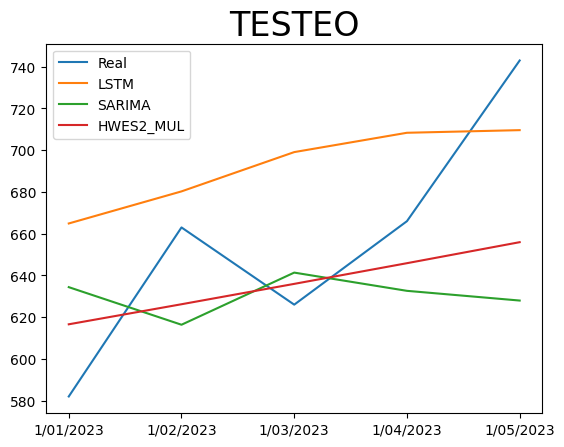

In [ ]:
plt.plot( pronosticos_rn_lstm[['UND_ORDEN','LSTM']][pronosticos_rn_lstm['ID']==1] )
plt.plot( pronosticos_sarima[['SARIMA']][pronosticos_sarima['ID']==1] )
plt.plot( pronosticos_smoothexponential[['HWES2_MUL']][pronosticos_smoothexponential['ID']==1] )

plt.title("TESTEO", size = 24)
plt.legend(['Real','LSTM','SARIMA','HWES2_MUL'])
plt.show()

In [ ]:
pronosticos_df

NameError: ignored